# **Notebook 2: Transfer Learning**

Mario Pedol (830296), 
Veronica Morelli (839257).

In this notebook we propose the approach of **Transfer Learning**.

We use completely a Pre-trained Neural Network (fine tuning) adding a Feed-Forward Neural Network to improve the performances.


##1) **Environment Set Up**

This section is made to configure the environment, import useful libraries and set up the directories:

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import pandas as pd
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
from keras import layers
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout, GlobalAveragePooling2D
from keras.models import Sequential,  Model
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import resnet50, MobileNet,VGG16
from tensorflow.keras.applications.resnet50 import preprocess_input as preprocess_input_resnet50
from tensorflow.keras.applications.mobilenet import preprocess_input as preprocess_inputMN
from tensorflow.keras.applications.vgg16 import preprocess_input as preprocess_inputVG



In [ ]:
# Import main libraries

from time import time
from datetime import datetime
from google.colab import drive

import cv2
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import load_img
print('TensorFlow version:', tf.__version__)

import zipfile
from shutil import copyfile

from matplotlib import pyplot as plt

import numpy as np
import random as python_random

import glob
import shutil
from random import seed
from random import random
import os
import os.path


from IPython.display import Javascript


TensorFlow version: 2.8.2


In [ ]:
# Set seed for reproducibility

!PYTHONHASHSEED = 0

np.random.seed(0)
python_random.seed(0)
tf.random.set_seed(0)

/bin/bash: PYTHONHASHSEED: command not found


In [ ]:
# Mount GDrive
drive.mount('/content/gdrive/', force_remount = True) 

Mounted at /content/gdrive/


# 2) **Modeling**: Transfer Learning

## **Principal Steps**

The principal steps to define a Neural Network are the following:

1.	Loading of the Pre-trained Neural Network;
2.  FFN Architecture Definition; 
3.	Compilation: definition of network macro-elements (optimizer, learning rate in the optimizer, loss function, additional metrics, parameters, etc.). 
4.	Training (epochs, batch size, etc.)
5.	Summary and Visualization of the results

###2.1) ResNet50v1

In [ ]:
base_path = '/content/gdrive/MyDrive/FDL2022Project/Dati/Sample/Train/'

To achieve better performance than those obtained on the networks previously developed in *notebook 1* we use **Transfer learning** (fine tuning) approach. The bese_model (aka pretrained model) choose for this work is the ResNet50.

To make the classificatory model as generalizable as possible on new data, the technique of data augmentation is used. Data augmentation creates a more complete and consistent set of data.

The batch size is set to 32, will be larger in the next step. Moreover, the image are rescale 1/255 (rgb) and  risize from 250x250 to 224x224 dimension (iterpolation = nearest), this is done to better adapt the dataset to the base model, that is train on imagnet (224x224)


In [ ]:
size=224
channels=3
batch_size = 32
num_classes = 5


train_processing = ImageDataGenerator(rescale=1.0/255,
                                      validation_split=0.2,
                                      rotation_range = 25,
                                      width_shift_range = .2,
                                      height_shift_range = .2,
                                      horizontal_flip = True,
                                      zoom_range = .2)

validation_datagen = ImageDataGenerator(rescale=1.0/255,
                                         validation_split=0.2)


train_generator = train_processing.flow_from_directory (base_path,   
                                                     target_size=(size, size), 
                                                     batch_size=batch_size,
                                                     shuffle=True,
                                                     class_mode='categorical',
                                                     subset='training',
                                                     color_mode="rgb",
                                                     interpolation='nearest')

validation_generator = validation_datagen.flow_from_directory(base_path,  
                                                              target_size=(size,size),
                                                              subset='validation',
                                                              color_mode="rgb",
                                                              batch_size=batch_size,
                                                              class_mode='categorical',
                                                              shuffle=False,
                                                              interpolation='nearest')


Found 3298 images belonging to 5 classes.
Found 823 images belonging to 5 classes.


In [ ]:
for image_batch, labels_batch in train_generator:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 224, 224, 3)
(32, 5)


In [ ]:
pretrained_model = resnet50.ResNet50(
    weights='imagenet', 
    include_top=False,  
    input_shape=(size, size, 3), 
    pooling='avg',  
)

94781440/94765736 [==============================] - 1s 0us/step


In [ ]:
print('Numero layers ResNet50: {}'.format(len(pretrained_model.layers)))


Numero layers ResNet50: 176


In [ ]:
layer_dict = dict([(layer.name, layer) for layer in pretrained_model.layers])

for layer in pretrained_model.layers:
    layer.trainable = False

After the basemodel is add a FFN built with the following layers:

- Dense layer 2048 neurons, activation function "relu".
- Dense layer 512 neurons, activation function "relu".
- Dropout layer 0.15.
- Output layer 5 output neurons, activation function "softmax".

In [ ]:
x1 = pretrained_model.output
x1 = Dense(2048, activation = 'relu')(x1)
x1 = Dense(512, activation='relu')(x1)
x1 = Dropout(0.2)(x1)
pred1 = Dense(5, activation = 'softmax')(x1)

In [ ]:
model1 =  Model(inputs=pretrained_model.input, outputs=pred1)

In [ ]:
model1.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

The optimizer used is Adam, the loss function is the categorical crossentropy and the metric is the Accuracy:

In [ ]:
model1.compile(
  optimizer='adam',
  loss='categorical_crossentropy',
  metrics=['accuracy'])

In [ ]:
history = model1.fit_generator(
    generator=train_generator,
    epochs=25,  
    validation_data=validation_generator)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  after removing the cwd from sys.path.


Epoch 1/25
104/104 [==============================] - 834s 8s/step - loss: 1.2993 - accuracy: 0.4524 - val_loss: 0.8563 - val_accuracy: 0.5638
Epoch 2/25
104/104 [==============================] - 48s 458ms/step - loss: 0.7202 - accuracy: 0.6825 - val_loss: 0.6224 - val_accuracy: 0.7290
Epoch 3/25
104/104 [==============================] - 48s 463ms/step - loss: 0.6732 - accuracy: 0.6977 - val_loss: 0.6652 - val_accuracy: 0.6731
Epoch 4/25
104/104 [==============================] - 48s 459ms/step - loss: 0.6202 - accuracy: 0.7341 - val_loss: 0.5169 - val_accuracy: 0.7886
Epoch 5/25
104/104 [==============================] - 48s 457ms/step - loss: 0.5678 - accuracy: 0.7562 - val_loss: 0.4289 - val_accuracy: 0.8360
Epoch 6/25
104/104 [==============================] - 49s 468ms/step - loss: 0.5513 - accuracy: 0.7547 - val_loss: 0.6192 - val_accuracy: 0.7060
Epoch 7/25
104/104 [==============================] - 48s 458ms/step - loss: 0.6160 - accuracy: 0.7353 - val_loss: 0.5333 - val_accu

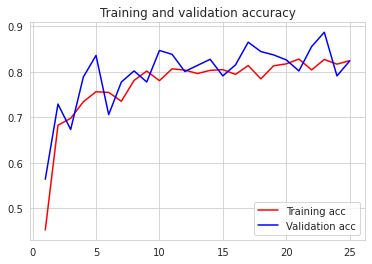

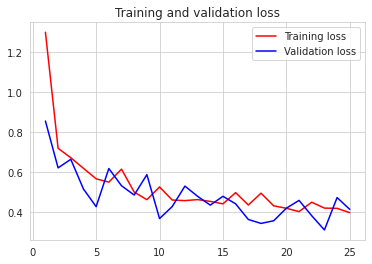

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

sns.set_style("whitegrid")
plt.title('Training and validation accuracy')
plt.plot(epochs, acc, 'red', label='Training acc')
plt.plot(epochs, val_acc, 'blue', label='Validation acc')
plt.legend()

plt.figure()
plt.title('Training and validation loss')
plt.plot(epochs, loss, 'red', label='Training loss')
plt.plot(epochs, val_loss, 'blue', label='Validation loss')

plt.legend()

plt.show()

The results show a strong overfitting on the train set, Traing loss is always under the Valdidation curve, the same is for the accuracy. Another consideration is that the net seems very unstable. 
Those consideration are keep to improve the net in the following steps.

In [ ]:
rice_classes=os.listdir(base_path)
print(rice_classes)

['Arborio', 'Basmati', 'Ipsala', 'Jasmine', 'Karacadag']


In [ ]:
Y_pred = model1.predict(validation_generator)
y_pred = np.argmax(Y_pred, axis=1)
report1 = classification_report(validation_generator.classes, y_pred, target_names=rice_classes, output_dict=True)
df1 = pd.DataFrame(report1).transpose()
df1

,precision,recall,f1-score,support
Arborio,0.744186,0.492308,0.592593,130.000000
Basmati,0.844037,0.978723,0.906404,188.000000
Ipsala,0.893023,1.000000,0.943489,192.000000
Jasmine,0.981481,0.588889,0.736111,180.000000
Karacadag,0.673469,0.992481,0.802432,133.000000
accuracy,0.823815,0.823815,0.823815,0.823815
macro avg,0.827239,0.810480,0.796206,823.000000
weighted avg,0.842189,0.823815,0.811439,823.000000


###2.2) ResNet50v2

To improve the previous network the batch size is set to 64 and a preprocessing function it's added to better adapt the data to the ResNet50.
it's defined a more complex FFN to try to achive a higher performace on the validation set

In [ ]:
size=224
channels=3
batch_size = 64
num_classes = 5


train_processing = ImageDataGenerator(preprocessing_function=preprocess_input_resnet50,
                                      validation_split=0.2,
                                      rotation_range = 25,
                                      width_shift_range = .2,
                                      height_shift_range = .2,
                                      horizontal_flip = True,
                                      zoom_range = .2)

validation_datagen = ImageDataGenerator(preprocessing_function=preprocess_input_resnet50,
                                        validation_split=0.2)


train_generator = train_processing.flow_from_directory (base_path,   
                                                     target_size=(size, size), 
                                                     batch_size=batch_size,
                                                     shuffle=True,
                                                     class_mode='categorical',
                                                     subset='training',
                                                     color_mode="rgb",
                                                     interpolation='nearest')

validation_generator = validation_datagen.flow_from_directory(base_path,  
                                                              target_size=(size,size),
                                                              subset='validation',
                                                              color_mode="rgb",
                                                              batch_size=batch_size,
                                                              class_mode='categorical',
                                                              shuffle=False,
                                                              interpolation='nearest')

Found 3840 images belonging to 5 classes.
Found 960 images belonging to 5 classes.


In [ ]:
for image_batch, labels_batch in train_generator:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(64, 224, 224, 3)
(64, 5)


In [ ]:
pretrained_model = resnet50.ResNet50(
    weights='imagenet', 
    include_top=False,  
    input_shape=(size, size, 3), 
    pooling='avg',  
)

In [ ]:
layer_dict = dict([(layer.name, layer) for layer in pretrained_model.layers])

for layer in pretrained_model.layers:
    layer.trainable = False

After the basemodel is add a FFN built with the following layers:

- Dense layer 2048 neurons, activation function "relu".
- Dense layer 512 neurons, activation function "relu".
- Dropout layer 0.15.
- Dense layer 128 neurons, activation function "relu".
- Dense layer 64 neurons, activation function "relu".
- Dropout layer 0.15.
- Dense layer 32 neurons, activation function "relu".
- Dense layer 16 neurons, activation function "relu".
- Output layer 5 output neurons, activation function "softmax".

In [ ]:
x2 = pretrained_model.output
x2 = Dense(2048,'relu')(x2)
x2 = Dense(512,'relu')(x2)
x2 = Dropout(.15)(x2)
x2 = Dense(128,'relu')(x2)
x2 = Dense(64,'relu')(x2)
x2 = Dropout(.15)(x2)
x2 = Dense(32,'relu')(x2)
x2 = Dense(16,'relu')(x2)
pred2 = Dense(5,'softmax')(x2)

model2 =  Model(inputs=pretrained_model.input, outputs=pred2)

In [ ]:
model2.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

In [ ]:
model2.compile(
  optimizer=tf.keras.optimizers.Adam(lr=0.0001),
  loss='categorical_crossentropy',
  metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss', mode='min',patience=3, 
                              verbose=1, factor=0.5, min_lr=0.000001)

In [ ]:
EarlyStopping=tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    min_delta=0,
    patience=3,
    verbose=0,
    mode='auto',
    baseline=None,
    restore_best_weights=True
)

In [ ]:
history = model2.fit_generator(
    generator=train_generator,
    epochs=25,  
    validation_data=validation_generator,
    callbacks=[reduce_lr, EarlyStopping])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  """


Epoch 1/25
60/60 [==============================] - 67s 1s/step - loss: 0.6948 - accuracy: 0.7437 - val_loss: 0.2462 - val_accuracy: 0.9135 - lr: 1.0000e-04
Epoch 2/25
60/60 [==============================] - 57s 946ms/step - loss: 0.2334 - accuracy: 0.9234 - val_loss: 0.1177 - val_accuracy: 0.9573 - lr: 1.0000e-04
Epoch 3/25
60/60 [==============================] - 57s 952ms/step - loss: 0.1812 - accuracy: 0.9401 - val_loss: 0.0857 - val_accuracy: 0.9646 - lr: 1.0000e-04
Epoch 4/25
60/60 [==============================] - 55s 911ms/step - loss: 0.1349 - accuracy: 0.9523 - val_loss: 0.1120 - val_accuracy: 0.9615 - lr: 1.0000e-04
Epoch 5/25
60/60 [==============================] - 54s 905ms/step - loss: 0.1235 - accuracy: 0.9583 - val_loss: 0.0525 - val_accuracy: 0.9771 - lr: 1.0000e-04
Epoch 6/25
60/60 [==============================] - 54s 904ms/step - loss: 0.0959 - accuracy: 0.9661 - val_loss: 0.0533 - val_accuracy: 0.9802 - lr: 1.0000e-04
Epoch 7/25
60/60 [=========================

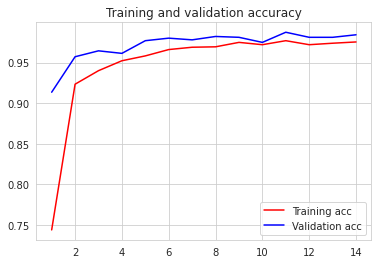

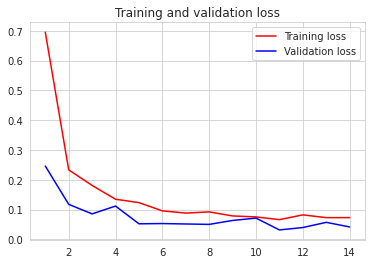

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

sns.set_style("whitegrid")
plt.title('Training and validation accuracy')
plt.plot(epochs, acc, 'red', label='Training acc')
plt.plot(epochs, val_acc, 'blue', label='Validation acc')
plt.legend()

plt.figure()
plt.title('Training and validation loss')
plt.plot(epochs, loss, 'red', label='Training loss')
plt.plot(epochs, val_loss, 'blue', label='Validation loss')

plt.legend()

plt.show()

In [ ]:
Y_pred = model2.predict(validation_generator)
y_pred = np.argmax(Y_pred, axis=1)
report1 = classification_report(validation_generator.classes, y_pred, target_names=rice_classes, output_dict=True)
df1 = pd.DataFrame(report1).transpose()
df1

,precision,recall,f1-score,support
Arborio,0.984615,1.000000,0.992248,192.0000
Basmati,0.994624,0.963542,0.978836,192.0000
Ipsala,0.994819,1.000000,0.997403,192.0000
Jasmine,0.964286,0.984375,0.974227,192.0000
Karacadag,1.000000,0.989583,0.994764,192.0000
accuracy,0.987500,0.987500,0.987500,0.9875
macro avg,0.987669,0.987500,0.987496,960.0000
weighted avg,0.987669,0.987500,0.987496,960.0000


the result is very satisfactory, the val acc achieved is 98% and the network never overfitted

###2.3) MobileNet

To see how the data behave on another pre-trained network, a MobileNet it's used to fine tune the model; all others parameters and architecture remain the same

In [ ]:
size=224
channels=3
batch_size = 64
num_classes = 5


train_processing = ImageDataGenerator(preprocessing_function=preprocess_inputMN,
                                      validation_split=0.2,
                                      rotation_range = 25,
                                      width_shift_range = .2,
                                      height_shift_range = .2,
                                      horizontal_flip = True,
                                      zoom_range = .2)

validation_datagen = ImageDataGenerator(preprocessing_function=preprocess_inputMN,
                                        validation_split=0.2)


train_generator = train_processing.flow_from_directory (base_path,   
                                                     target_size=(size, size), 
                                                     batch_size=batch_size,
                                                     shuffle=True,
                                                     class_mode='categorical',
                                                     subset='training',
                                                     color_mode="rgb",
                                                     interpolation='nearest')

validation_generator = validation_datagen.flow_from_directory(base_path,  
                                                              target_size=(size,size),
                                                              subset='validation',
                                                              color_mode="rgb",
                                                              batch_size=batch_size,
                                                              class_mode='categorical',
                                                              shuffle=False,
                                                              interpolation='nearest')

Found 3840 images belonging to 5 classes.
Found 960 images belonging to 5 classes.


In [ ]:
pretrained_model = MobileNet(
    weights='imagenet', 
    input_shape=(size, size, 3), 
    pooling='avg'  
)

17235968/17225924 [==============================] - 0s 0us/step


In [ ]:
print('Numero layers MobileNet: {}'.format(len(pretrained_model.layers)))

Numero layers MobileNet: 91


In [ ]:
layer_dict = dict([(layer.name, layer) for layer in pretrained_model.layers])

for layer in pretrained_model.layers:
    layer.trainable = False

In [ ]:
x3 = pretrained_model.output
x3 = Dense(2048,'relu')(x3)
x3 = Dense(512,'relu')(x3)
x3 = Dropout(.15)(x3)
x3 = Dense(128,'relu')(x3)
x3 = Dense(64,'relu')(x3)
x3 = Dropout(.15)(x3)
x3 = Dense(32,'relu')(x3)
x3 = Dense(16,'relu')(x3)
pred3 = Dense(5,'softmax')(x3)

model3 =  Model(inputs=pretrained_model.input, outputs=pred3)

In [ ]:
model3.compile(
  optimizer=tf.keras.optimizers.Adam(lr=0.0001),
  loss='categorical_crossentropy',
  metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
model3.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                                    

In [ ]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss', mode='min',patience=3, 
                              verbose=1, factor=0.5, min_lr=0.000001)

<IPython.core.display.Javascript object>

In [ ]:
EarlyStopping=tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    min_delta=0,
    patience=3,
    verbose=0,
    mode='auto',
    baseline=None,
    restore_best_weights=True
)

<IPython.core.display.Javascript object>

In [ ]:
history = model3.fit_generator(
    generator=train_generator,
    epochs=25,  
    validation_data=validation_generator,
    callbacks=[reduce_lr, EarlyStopping])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  """


Epoch 1/25
60/60 [==============================] - 63s 1s/step - loss: 1.5497 - accuracy: 0.4026 - val_loss: 1.4257 - val_accuracy: 0.4615 - lr: 1.0000e-04
Epoch 2/25
60/60 [==============================] - 53s 879ms/step - loss: 1.3393 - accuracy: 0.5005 - val_loss: 1.1824 - val_accuracy: 0.5292 - lr: 1.0000e-04
Epoch 3/25
60/60 [==============================] - 53s 888ms/step - loss: 1.1176 - accuracy: 0.5911 - val_loss: 0.9553 - val_accuracy: 0.6542 - lr: 1.0000e-04
Epoch 4/25
60/60 [==============================] - 52s 868ms/step - loss: 0.9112 - accuracy: 0.6695 - val_loss: 0.8074 - val_accuracy: 0.7115 - lr: 1.0000e-04
Epoch 5/25
60/60 [==============================] - 53s 883ms/step - loss: 0.7821 - accuracy: 0.7198 - val_loss: 0.7451 - val_accuracy: 0.7448 - lr: 1.0000e-04
Epoch 6/25
60/60 [==============================] - 54s 895ms/step - loss: 0.6708 - accuracy: 0.7628 - val_loss: 0.6923 - val_accuracy: 0.7146 - lr: 1.0000e-04
Epoch 7/25
60/60 [=========================

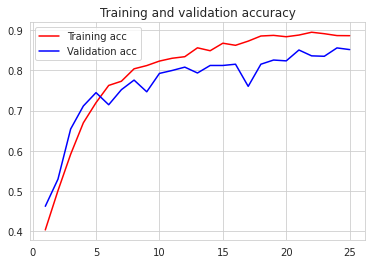

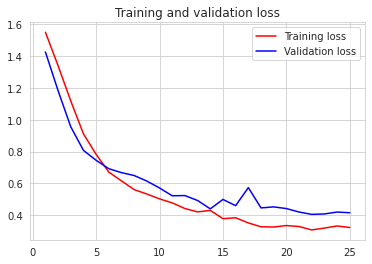

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

sns.set_style("whitegrid")
plt.title('Training and validation accuracy')
plt.plot(epochs, acc, 'red', label='Training acc')
plt.plot(epochs, val_acc, 'blue', label='Validation acc')
plt.legend()

plt.figure()
plt.title('Training and validation loss')
plt.plot(epochs, loss, 'red', label='Training loss')
plt.plot(epochs, val_loss, 'blue', label='Validation loss')

plt.legend()

plt.show()

In [ ]:
Y_pred = model3.predict(validation_generator)
Y_pred = model3.predict(validation_generator)
y_pred = np.argmax(Y_pred, axis=1)
report1 = classification_report(validation_generator.classes, y_pred, target_names=rice_classes, output_dict=True)
df1 = pd.DataFrame(report1).transpose()
df1

,precision,recall,f1-score,support
Arborio,0.976378,0.645833,0.777429,192.000000
Basmati,0.941176,0.916667,0.928760,192.000000
Ipsala,0.694444,0.911458,0.788288,192.000000
Jasmine,0.925287,0.838542,0.879781,192.000000
Karacadag,0.827273,0.947917,0.883495,192.000000
accuracy,0.852083,0.852083,0.852083,0.852083
macro avg,0.872912,0.852083,0.851551,960.000000
weighted avg,0.872912,0.852083,0.851551,960.000000


The results dosen't show any improvent from the previous network, instead, it overfit and achive a val acc just of 85%.

###2.4) VGG16

Another pre-trained Neural Network it's used for fine tuning, VGG16.

In [ ]:
size=224


In [ ]:
size=224
channels=3
batch_size = 64
num_classes = 5


train_processing = ImageDataGenerator(preprocessing_function=preprocess_inputVG,
                                      validation_split=0.2,
                                      rotation_range = 25,
                                      width_shift_range = .2,
                                      height_shift_range = .2,
                                      horizontal_flip = True,
                                      zoom_range = .2)

validation_datagen = ImageDataGenerator(preprocessing_function=preprocess_inputVG,
                                        validation_split=0.2)


train_generator = train_processing.flow_from_directory (base_path,   
                                                     target_size=(size, size), 
                                                     batch_size=batch_size,
                                                     shuffle=True,
                                                     class_mode='categorical',
                                                     subset='training',
                                                     color_mode="rgb",
                                                     interpolation='nearest')

validation_generator = validation_datagen.flow_from_directory(base_path,  
                                                              target_size=(size,size),
                                                              subset='validation',
                                                              color_mode="rgb",
                                                              batch_size=batch_size,
                                                              class_mode='categorical',
                                                              shuffle=False,
                                                              interpolation='nearest')

Found 3840 images belonging to 5 classes.
Found 960 images belonging to 5 classes.


In [ ]:
pretrained_model = VGG16(
    weights='imagenet', 
    input_shape=(size, size, 3), 
    pooling='avg'  
)

553476096/553467096 [==============================] - 10s 0us/step


In [ ]:
print('Numero layers MobileNet: {}'.format(len(pretrained_model.layers)))

Numero layers MobileNet: 23


In [ ]:
layer_dict = dict([(layer.name, layer) for layer in pretrained_model.layers])

for layer in pretrained_model.layers:
    layer.trainable = False

In [ ]:
x4 = pretrained_model.output
x4 = Dense(2048,'relu')(x4)
x4 = Dense(512,'relu')(x4)
x4 = Dropout(.15)(x4)
x4 = Dense(128,'relu')(x4)
x4 = Dense(64,'relu')(x4)
x4 = Dropout(.15)(x4)
x4 = Dense(32,'relu')(x4)
x4 = Dense(16,'relu')(x4)
pred4 = Dense(5,'softmax')(x4)

model4 =  Model(inputs=pretrained_model.input, outputs=pred4)

In [ ]:
model4.compile(
  optimizer=tf.keras.optimizers.Adam(lr=0.0001),
  loss='categorical_crossentropy',
  metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
model4.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [ ]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss', mode='min',patience=3, 
                              verbose=1, factor=0.5, min_lr=0.000001)

In [ ]:
EarlyStopping=tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    min_delta=0,
    patience=3,
    verbose=0,
    mode='auto',
    baseline=None,
    restore_best_weights=True
)

In [ ]:
history = model4.fit_generator(
    generator=train_generator,
    epochs=25,  
    validation_data=validation_generator,
    callbacks=[reduce_lr, EarlyStopping])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  """


Epoch 1/25
60/60 [==============================] - 68s 1s/step - loss: 1.5693 - accuracy: 0.3773 - val_loss: 1.4546 - val_accuracy: 0.3875 - lr: 1.0000e-04
Epoch 2/25
60/60 [==============================] - 58s 963ms/step - loss: 1.3085 - accuracy: 0.4086 - val_loss: 1.0835 - val_accuracy: 0.5938 - lr: 1.0000e-04
Epoch 3/25
60/60 [==============================] - 59s 978ms/step - loss: 1.0516 - accuracy: 0.5482 - val_loss: 0.8558 - val_accuracy: 0.6948 - lr: 1.0000e-04
Epoch 4/25
60/60 [==============================] - 60s 1s/step - loss: 0.9076 - accuracy: 0.6190 - val_loss: 0.7453 - val_accuracy: 0.7240 - lr: 1.0000e-04
Epoch 5/25
60/60 [==============================] - 58s 962ms/step - loss: 0.8299 - accuracy: 0.6565 - val_loss: 0.7095 - val_accuracy: 0.7000 - lr: 1.0000e-04
Epoch 6/25
60/60 [==============================] - 58s 966ms/step - loss: 0.7720 - accuracy: 0.6740 - val_loss: 0.6654 - val_accuracy: 0.7302 - lr: 1.0000e-04
Epoch 7/25
60/60 [============================

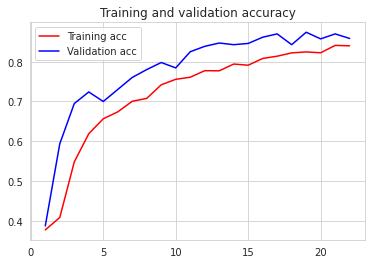

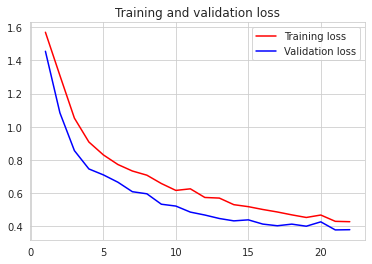

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

sns.set_style("whitegrid")
plt.title('Training and validation accuracy')
plt.plot(epochs, acc, 'red', label='Training acc')
plt.plot(epochs, val_acc, 'blue', label='Validation acc')
plt.legend()

plt.figure()
plt.title('Training and validation loss')
plt.plot(epochs, loss, 'red', label='Training loss')
plt.plot(epochs, val_loss, 'blue', label='Validation loss')

plt.legend()

plt.show()

In [ ]:
Y_pred = model4.predict(validation_generator)
y_pred = np.argmax(Y_pred, axis=1)
report1 = classification_report(validation_generator.classes, y_pred, target_names=rice_classes, output_dict=True)
df1 = pd.DataFrame(report1).transpose()
df1

,precision,recall,f1-score,support
Arborio,0.797980,0.822917,0.810256,192.000000
Basmati,0.930108,0.901042,0.915344,192.000000
Ipsala,0.858537,0.916667,0.886650,192.000000
Jasmine,0.905556,0.848958,0.876344,192.000000
Karacadag,0.884817,0.880208,0.882507,192.000000
accuracy,0.873958,0.873958,0.873958,0.873958
macro avg,0.875399,0.873958,0.874220,960.000000
weighted avg,0.875399,0.873958,0.874220,960.000000


The results show a very good trend of the Val/loss curves, although the accuracy is not very high. This prompts us to look for improvements without changing the network.

###2.5) VGG16 cut 1

In this model we try to cut the pre_trained network to an higher level.

In [ ]:
x5 = layer_dict['block3_pool'].output
x5 = GlobalAveragePooling2D()(x5)
x5 = Dense(2048,'relu')(x5)
x5 = Dense(512,'relu')(x5)
x5 = Dropout(.15)(x5)
x5 = Dense(128,'relu')(x5)
x5 = Dense(64,'relu')(x5)
x5 = Dropout(.15)(x5)
x5 = Dense(32,'relu')(x5)
x5 = Dense(16,'relu')(x5)
pred5 = Dense(5, activation='softmax')(x5)

In [ ]:
model5 =  Model(inputs=pretrained_model.input, outputs=pred5)

In [ ]:
model5.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
model5.compile(
  optimizer=tf.keras.optimizers.Adam(lr=0.0001),
  loss='categorical_crossentropy',
  metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
history = model5.fit_generator(
    generator=train_generator,
    epochs=25,  
    validation_data=validation_generator,
    callbacks=[reduce_lr, EarlyStopping])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  """


Epoch 1/25
60/60 [==============================] - 57s 921ms/step - loss: 8.3571 - accuracy: 0.3076 - val_loss: 1.2231 - val_accuracy: 0.5177 - lr: 1.0000e-04
Epoch 2/25
60/60 [==============================] - 55s 917ms/step - loss: 2.2639 - accuracy: 0.4750 - val_loss: 0.4441 - val_accuracy: 0.8656 - lr: 1.0000e-04
Epoch 3/25
60/60 [==============================] - 56s 927ms/step - loss: 1.3115 - accuracy: 0.5867 - val_loss: 0.5224 - val_accuracy: 0.7719 - lr: 1.0000e-04
Epoch 4/25
60/60 [==============================] - 55s 911ms/step - loss: 0.8853 - accuracy: 0.6747 - val_loss: 0.3740 - val_accuracy: 0.9021 - lr: 1.0000e-04
Epoch 5/25
60/60 [==============================] - 55s 910ms/step - loss: 0.6925 - accuracy: 0.7424 - val_loss: 0.2728 - val_accuracy: 0.9156 - lr: 1.0000e-04
Epoch 6/25
60/60 [==============================] - 56s 938ms/step - loss: 0.5798 - accuracy: 0.7828 - val_loss: 0.3020 - val_accuracy: 0.9010 - lr: 1.0000e-04
Epoch 7/25
60/60 [======================

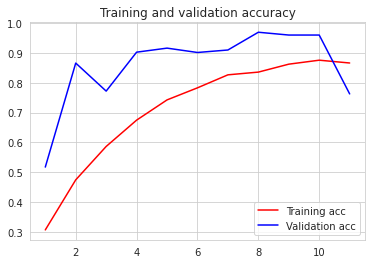

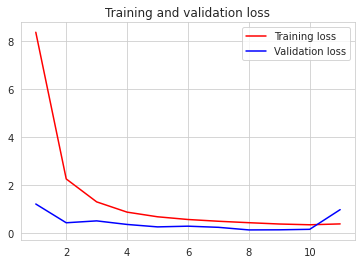

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

sns.set_style("whitegrid")
plt.title('Training and validation accuracy')
plt.plot(epochs, acc, 'red', label='Training acc')
plt.plot(epochs, val_acc, 'blue', label='Validation acc')
plt.legend()

plt.figure()
plt.title('Training and validation loss')
plt.plot(epochs, loss, 'red', label='Training loss')
plt.plot(epochs, val_loss, 'blue', label='Validation loss')

plt.legend()

plt.show()

the results show a very good performance on the fisrt epochs, 96% on val acc, and a worsening on the last epoch.

###2.6) VGG16 taglio2

Now another cut is made on a lower level to see if there is any improvment.

In [ ]:
x6 = layer_dict['block4_pool'].output
x6 = GlobalAveragePooling2D()(x6)
x6 = Dense(2048,'relu')(x6)
x6 = Dense(512,'relu')(x6)
x6 = Dropout(.15)(x6)
x6 = Dense(128,'relu')(x6)
x6 = Dense(64,'relu')(x6)
x6 = Dropout(.15)(x6)
x6 = Dense(32,'relu')(x6)
x6 = Dense(16,'relu')(x6)
pred6 = Dense(5, activation='softmax')(x6)

In [ ]:
model6 =  Model(inputs=pretrained_model.input, outputs=pred6)

In [ ]:
model6.compile(
  optimizer=tf.keras.optimizers.Adam(lr=0.0001),
  loss='categorical_crossentropy',
  metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
history = model6.fit_generator(
    generator=train_generator,
    epochs=25,  
    validation_data=validation_generator,
    callbacks=[EarlyStopping])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  """


Epoch 1/25
60/60 [==============================] - 58s 955ms/step - loss: 1.8115 - accuracy: 0.3409 - val_loss: 1.0119 - val_accuracy: 0.5792
Epoch 2/25
60/60 [==============================] - 56s 939ms/step - loss: 1.0698 - accuracy: 0.5326 - val_loss: 0.7205 - val_accuracy: 0.7542
Epoch 3/25
60/60 [==============================] - 56s 936ms/step - loss: 0.8094 - accuracy: 0.6604 - val_loss: 0.5155 - val_accuracy: 0.7594
Epoch 4/25
60/60 [==============================] - 56s 938ms/step - loss: 0.5561 - accuracy: 0.7820 - val_loss: 0.2765 - val_accuracy: 0.9333
Epoch 5/25
60/60 [==============================] - 58s 964ms/step - loss: 0.3854 - accuracy: 0.8682 - val_loss: 0.2312 - val_accuracy: 0.9271
Epoch 6/25
60/60 [==============================] - 56s 937ms/step - loss: 0.2916 - accuracy: 0.8990 - val_loss: 0.1710 - val_accuracy: 0.9615
Epoch 7/25
60/60 [==============================] - 56s 937ms/step - loss: 0.2101 - accuracy: 0.9305 - val_loss: 0.1100 - val_accuracy: 0.9760

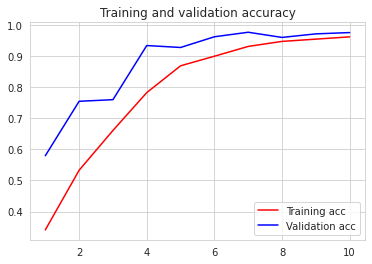

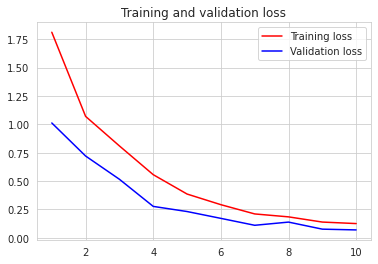

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

sns.set_style("whitegrid")
plt.title('Training and validation accuracy')
plt.plot(epochs, acc, 'red', label='Training acc')
plt.plot(epochs, val_acc, 'blue', label='Validation acc')
plt.legend()

plt.figure()
plt.title('Training and validation loss')
plt.plot(epochs, loss, 'red', label='Training loss')
plt.plot(epochs, val_loss, 'blue', label='Validation loss')

plt.legend()

plt.show()

The results show a performance that is very similar to one achieved on the ResNet50.